In [1]:
import tidy3d as td
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run_local as run

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
import jax
import jax.numpy as jnp

In [4]:
wavelength = 1.0
freq0 = td.C_0 / wavelength

fwidth = freq0 / 10
num_freqs = 10
freqs = np.linspace(freq0 - fwidth/2, freq0 + fwidth/2, num_freqs)

num_pts = 40
angles = np.linspace(0, np.pi/2, num_pts + 2)[1:-1]

n_wg = 2.0

spc = 1 * wavelength
t = 1 * wavelength
mode_spc = t / 2.0

wmid = 0.6 * wavelength
wmax = 0.9 * wavelength
wmin = 0.3 * wavelength

radius = 3 * wavelength

monitor_name = "mode"

min_steps_per_wvl = 25

In [5]:
Lx = Ly = t + radius + abs(wmax - wmid) + spc
Lz = 0.0

In [6]:
def thickness(param: float) -> float:
    param_01 = (jnp.tanh(param) + 1.0) / 2.0
    return wmax * param_01 + wmin * (1 - param_01)

In [26]:
def make_vertices(params):
    vertices = []
    vertices.append((Lx/2 - t, Ly/2 - t - radius - wmid/2))
    for angle, param in zip(angles, params):
        thickness_i = thickness(param)
        radius_i = radius + thickness_i/2.0
        x = -radius_i * np.sin(angle) + Lx/2 - t
        y = -radius_i * np.cos(angle) + Ly/2 - t
        vertices.append((x, y))
    vertices.append((Lx/2 - t - radius - wmid/2, Ly/2 - t))
    vertices.append((Lx/2 - t - radius + wmid/2, Ly/2 - t))
    for angle, param in zip(angles[::-1], params[::-1]):
        thickness_i = thickness(param)
        radius_i = radius - thickness_i/2.0
        x = -radius_i * np.sin(angle) + Lx/2 - t
        y = -radius_i * np.cos(angle) + Ly/2 - t
        vertices.append((x, y))    
    vertices.append((Lx/2 - t, Ly/2 - t - radius + wmid/2))
    return vertices
        


In [27]:
params = 0 * np.random.random(num_pts) - 0.5 * 0
vertices = make_vertices(params)

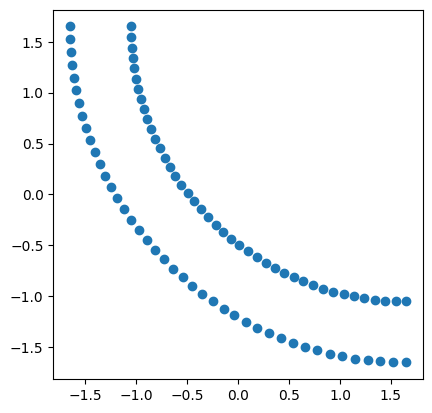

In [28]:
plt.scatter(*np.array(vertices).T)
ax = plt.gca()
ax.set_aspect("equal")

In [29]:
def make_polyslab(params) -> tda.JaxPolySlab:
    vertices = make_vertices(params)
    return tda.JaxPolySlab(
        vertices=vertices,
        slab_bounds=(-1,1),
        axis=2,
    )    

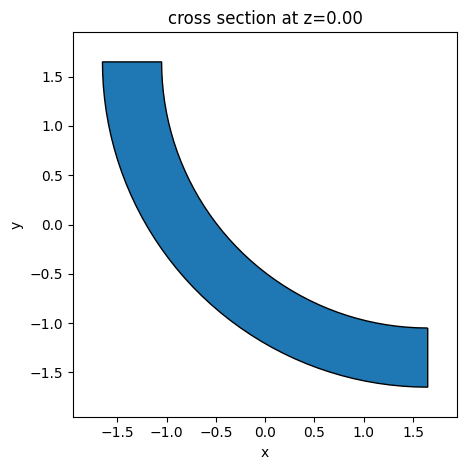

In [30]:
polyslab = make_polyslab(params)
ax = polyslab.plot(z=0)

In [31]:
def make_input_structures(params) -> list[tda.JaxPolySlab]:
    polyslab = make_polyslab(params)
    medium = tda.JaxMedium(permittivity=n_wg**2)
    return [tda.JaxStructure(geometry=polyslab, medium=medium)]

box_in = td.Box.from_bounds(
    rmin=(Lx/2 - t, Ly/2 - t - radius - wmid/2, -1),
    rmax=(Lx/2 + 1, Ly/2 - t - radius + wmid/2, +1),
)
box_out = td.Box.from_bounds(
    rmin=(Lx/2 - t - radius - wmid/2, Ly/2 - t, -1),
    rmax=(Lx/2 - t - radius + wmid/2, Ly/2 + 1, +1),
)
wg_in = td.Structure(geometry=box_in, medium=td.Medium(permittivity=n_wg**2))
wg_out = td.Structure(geometry=box_out, medium=td.Medium(permittivity=n_wg**2))


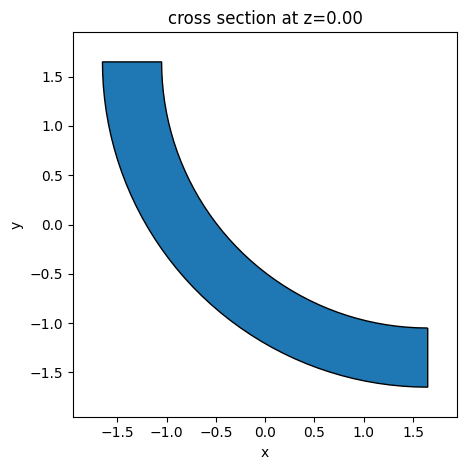

In [32]:
(ring,) = input_structures = make_input_structures(params)
ax = ring.plot(z=0)

In [33]:
mode_size = wmax * 4

mode_src = td.ModeSource(
    size=(mode_size, 0, 1),
    center=(Lx/2 - t - radius, +Ly/2 - t/2, 0),    
    direction="-",
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    )
)

In [34]:
mode_mnt = td.ModeMonitor(
    size=(0, mode_size, 1),
    center=(Lx/2 - t/2, Ly/2 - t - radius, 0),
    name=monitor_name,
    freqs=[freq0],
    mode_spec=td.ModeSpec(),
)

mode_mnt_bb = td.ModeMonitor(
    size=(0, mode_size, 1),
    center=(Lx/2 - t/2, Ly/2 - t - radius, 0),
    name="mode_bb",
    freqs=freqs.tolist(),
    mode_spec=td.ModeSpec(),
)

fld_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

In [35]:

def make_sim(params, use_fld_mnt: bool = True) -> tda.JaxSimulation:
    monitors = [mode_mnt_bb]
    if use_fld_mnt:
        monitors += [fld_mnt]
    input_structures = make_input_structures(params)
    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        input_structures=input_structures,
        structures=[wg_in, wg_out],
        sources=[mode_src],
        output_monitors=[mode_mnt],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        monitors=monitors,
        run_time = 10/fwidth,
)

[11:23:40] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=169308;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=680358;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=65999;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=543445;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

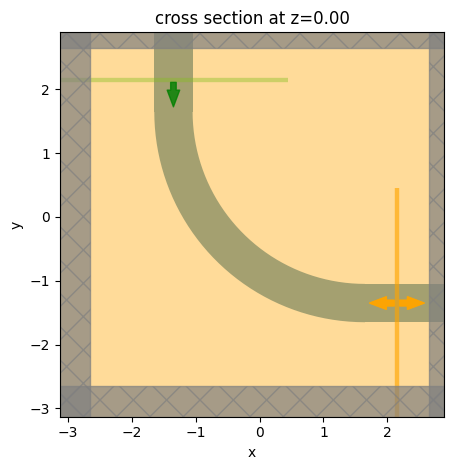

In [36]:
sim = make_sim(params)
ax = sim.plot(z=0)

In [37]:
from tidy3d.plugins.adjoint.utils.penalty import RadiusPenalty

penalty = RadiusPenalty(min_radius=0.150, alpha=1.0, kappa=10.0)


In [38]:
def transmission(params, use_fld_mnt:bool = True):
    sim = make_sim(params, use_fld_mnt=use_fld_mnt)
    sim_data = run(sim, task_name='bend', verbose=False)
    amps = sim_data[monitor_name].amps.sel(direction="+").values
    transmission = jnp.abs(jnp.array(amps))**2
    vertices = make_vertices(params)
    J = jnp.sum(transmission) - penalty.evaluate(vertices)
    return J

In [39]:
transmission(params)

[11:23:44] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=340270;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=939709;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=558084;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=104414;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=675320;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=103703;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=509922;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=557000;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

[11:24:13] WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=7892;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=210821;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=18212;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=955483;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

           WARNING: 'JaxPolySlab'-containing 'JaxSimulation.input_structures[0]' intersects with  ]8;id=667764;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=465392;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/adjoint/components/simulation.py#189\189]8;;\
           'JaxSimulation.structures[0]'. Note that in this version of the adjoint plugin, there                   
           may be errors in the gradient when 'JaxPolySlab' intersects with background                             
           structures.                                                                                             

           WARNING: Suppressed 1 WARNING message.                                                        ]8;id=993695;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=73960;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#127\127]8;;\

Array(1.7155471, dtype=float32)